# RBA SOMP Forecasts

## Set-up

In [1]:
# system imports
from pathlib import Path

import abs_data_capture

# local imports
import common

# analytic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from plotting import clear_chart_dir, finalise_plot, set_chart_dir

# plotting constants
chart_dir = "./CHARTS/SOMP"
Path(chart_dir).mkdir(parents=True, exist_ok=True)
clear_chart_dir(chart_dir)
set_chart_dir(chart_dir)
plt.style.use("fivethirtyeight")
SHOW = True

## Collect SOMP data

### Get raw SOMP tables

In [2]:
Q = {"feb": 1, "may": 2, "aug": 3, "nov": 4}
START_YEAR = 2019
STOP_YEAR = 2025  # - this will need updating from year to year


def collect_somp_data() -> dict[str, list[pd.DataFrame]]:
    """Collect raw SOMP data."""

    cache_dir = "./RBA_SOMP_CACHE"
    cache = Path(cache_dir)
    cache.mkdir(parents=True, exist_ok=True)

    pool = {}
    for year in range(START_YEAR, STOP_YEAR):
        for qtr in Q:
            url = (
                "https://www.rba.gov.au/publications"
                f"/smp/{year}/{qtr}/forecasts.html"
            )
            try:
                file = common.get_file(url, cache)
            except common.HttpError as e:
                print(f"Did not get: {year}-{qtr}")
                continue

            frame = pd.read_html(file, index_col=0)
            q = Q[qtr]
            index = f"{year}-Q{q}"
            pool[index] = frame

    return pool


raw_somp = collect_somp_data()

Retrieving data from cache: RBA_SOMP_CACHE/a1379dd0a92bd4626c9f86a01864ca7a--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/73d98da9e9b4cb61f9a2b7ec484666c8--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/dbc5bd06d495148c7ec5d9f423911d09--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/9a5ae921c14572463601b945bf77e2ac--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/67549187a6a3d7fffe7a792631b7b08d--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/b37e01367aeff06d7982501f07bb0dbe--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/6c8ad34d268f122e9d7f2dc5231e1fdc--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/bab514a8e41482bad760e1d86696c366--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/e8497feee2f9cc80ff8502b518709a2c--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/889b66a1af4e66f440c092d128094cf3--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/935401f104a40cf7282a69bdc3c647fd--for

### Reorganise SOMP data

In [3]:
def reorganise_somp(raw_somp) -> dict[str, pd.DataFrame]:
    """Reorganise the SOMP data into domains."""

    ue = "Unemployment rate"
    pool = {}
    for index, table in raw_somp.items():
        p = pd.Period(index, freq="Q-NOV")

        frame = table[0]
        for item in frame.index:
            if item[0] == "(":
                continue  # ignore footnotes
            row = frame.loc[item]
            row.name = index
            item_adj = ue if ue in item else item
            if item_adj not in pool:
                pool[item_adj] = pd.DataFrame(row)
            else:
                pool[item_adj] = pd.concat([pool[item_adj], pd.DataFrame(row)], axis=1)

    for item in pool:
        pool[item].columns = pd.PeriodIndex(pool[item].columns, freq="Q-NOV")
        pool[item].index = pd.PeriodIndex(pool[item].index, freq="Q-DEC")
        for col in pool[item].columns:
            pool[item][col] = (
                pool[item][col]
                .str.replace("¼", ".25")
                .str.replace("½", ".5")
                .str.replace("¾", ".75")
                .str.replace("−", "-")
                .astype(float)
            )

    return pool


somp = reorganise_somp(raw_somp)

In [4]:
somp.keys()

dict_keys(['Gross domestic product', 'Household consumption', 'Dwelling investment', 'Business investment', 'Public demand', 'Gross national expenditure', 'Imports', 'Exports', 'Real household disposable income', 'Terms of trade', 'Major trading partner (export-weighted) GDP', 'Unemployment rate', 'Employment', 'Wage price index', 'Nominal (non-farm) average earnings per hour', 'Trimmed mean inflation', 'Consumer price index'])

## Annual Growth Measures

In [13]:
growth_measures = {
    "Gross domestic product": [
        "5206",
        "1",
        "SA",
        "Chain volume measures ;",
        "Gross domestic product:",
        True,
    ],
    "Household consumption": [
        "5206",
        "8",
        "SA",
        "Chain volume measures ;",
        "FINAL CONSUMPTION EXPENDITURE:",
        True,
    ],
    "Dwelling investment": [
        "5206",
        "2",
        "SA",
        "Private ;  Gross fixed capital formation - Dwellings - Total ;",
        "Private ;  Gross fixed capital formation - Dwellings - Total ;",
        True,
    ],
    #"Business investment": [
    #
    #    # -- Needs work - ‘Business investment’ and ‘Public demand’ have been 
    #    # adjusted to exclude the effects of net sales of existing capital 
    #    # assets between the private and other (public and external) sectors.
    #    
    #    "5206",
    #    "2",
    #    "SA",
    #    "Private ;  Gross fixed capital formation ;",
    #    "Private ;  Gross fixed capital formation ;",
    #    True,
    #],
    #"Public demand": [
    #
    #    # Needs work - see above
    #    
    #    "5206",
    #    "24",
    #    "SA",
    #    "Public ;  Final demand: Chain volume measures ;",
    #    "Public ;  Final demand: Chain volume measures ;",
    #    True,
    #],
    "Gross national expenditure": [
        "5206",
        "2",
        "SA",
        "Gross national expenditure ;",
        "Gross national expenditure ;",
        True,
    ],
    "Imports": [
        "5206",
        "2",
        "SA",
        "Imports of goods and services ;",
        "Imports of goods and services ;",
        True,
    ],
    "Exports": [
        "5206",
        "2",
        "SA",
        "Exports of goods and services ;",
        "Exports of goods and services ;",
        True,
    ],
    "Nominal (non-farm) average earnings per hour": [
        "5206",
        "24",
        "SA",
        "Non-farm compensation of employees per hour: Current prices ;",
        "Non-farm compensation of employees per hour: Current prices ;",
        True,
    ],
    "Wage price index": [
        "6345",
        "1",
        "SA",
        "Percentage Change From Corresponding Quarter of Previous Year",
        "Australia ;  Total hourly rates of pay excluding bonuses ;  "
        + "Private and Public ;  All industries ;",
        False,
    ],
    "Trimmed mean inflation": [
        "6401",
        "8",
        "SA",
        "Percentage Change from Corresponding Quarter of Previous Year",
        "Trimmed Mean ;  Australia ;",
        False,
    ],
    "Consumer price index": [
        "6401",
        "2",
        "Orig",
        "Percentage Change from Corresponding Quarter of Previous Year",
        "All groups CPI ;  Australia ;",
        False,
    ],
}


def get_abs(measure_set):
    pool = {}
    (
        did_col,
        id_col,
        table_col,
        type_col,
        unit_col,
        tdesc_col,
    ) = abs_data_capture.get_meta_constants()

    for m, (cat, table, season, did1, did2, calc) in measure_set.items():
        print(m)

        # get the ABS data
        data_dict = abs_data_capture.get_abs_meta_and_data(cat)
        _, _, meta_data = abs_data_capture.get_fs_constants(cat)
        meta = data_dict[meta_data]
        data = data_dict[table]

        # get the specific series we want to plot
        search_terms = {
            table: table_col,
            {"SA": "Seasonally Adjusted", "Orig": "Original"}[season]: type_col,
            did1: did_col,
            did2: did_col,
        }
        series_id, _ = abs_data_capture.find_id(meta, search_terms, verbose=True)
        series = data[series_id]
        index = series.index
        if calc:
            series = (series / series.shift(4) - 1) * 100.0
        pool[m] = series

    return pool


abs_annual_growth = get_abs(growth_measures)

Gross domestic product
Household consumption
Dwelling investment
Gross national expenditure
Imports
Exports
Nominal (non-farm) average earnings per hour
Wage price index
Trimmed mean inflation
Consumer price index


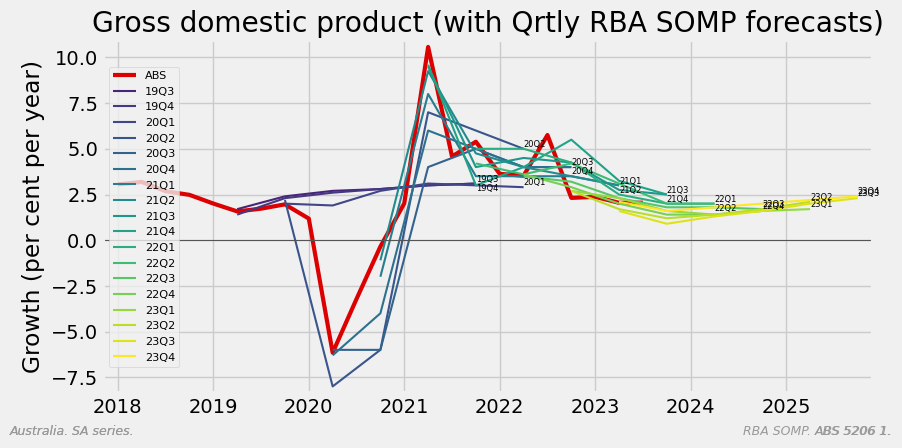

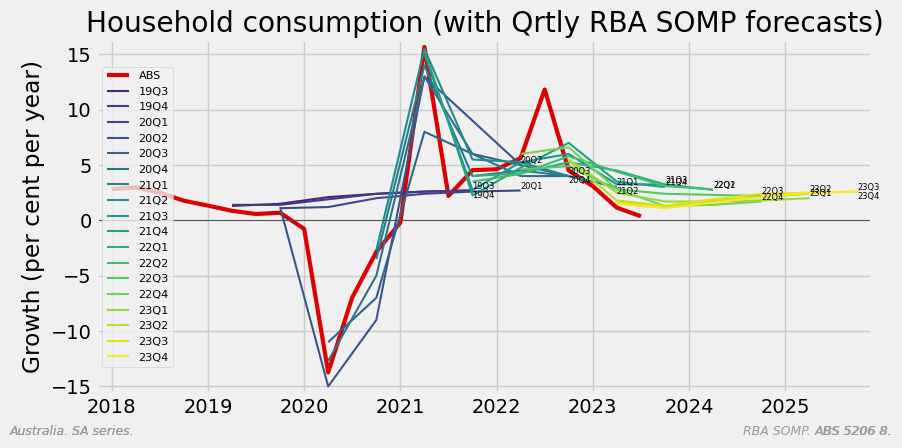

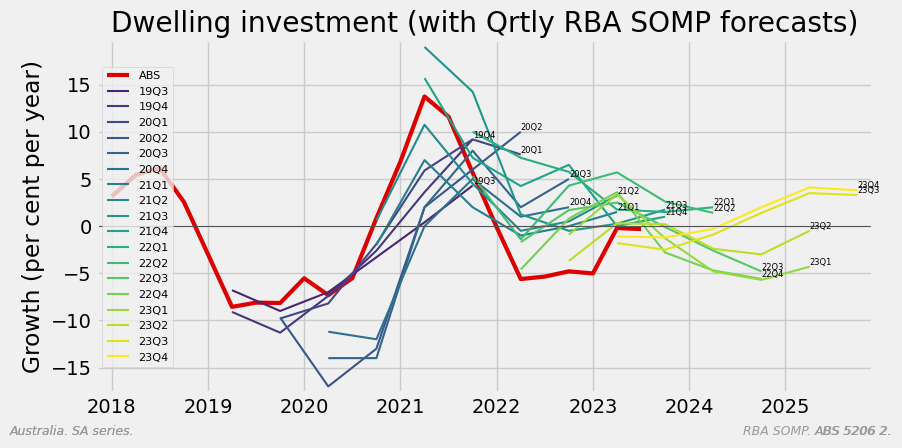

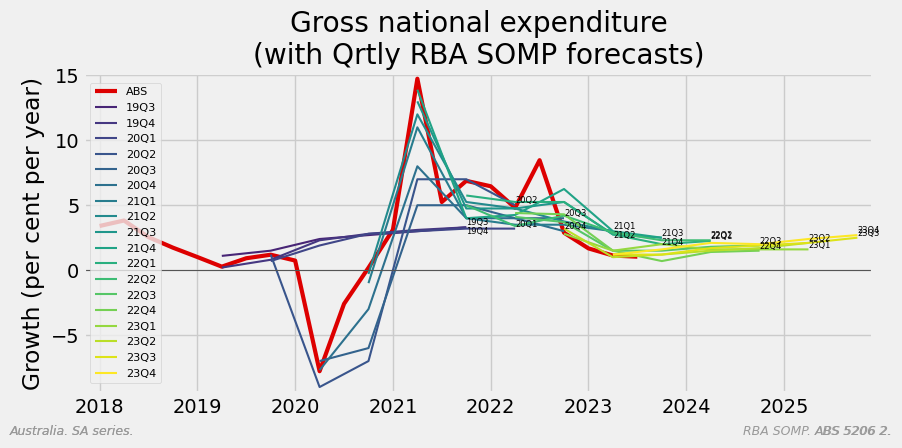

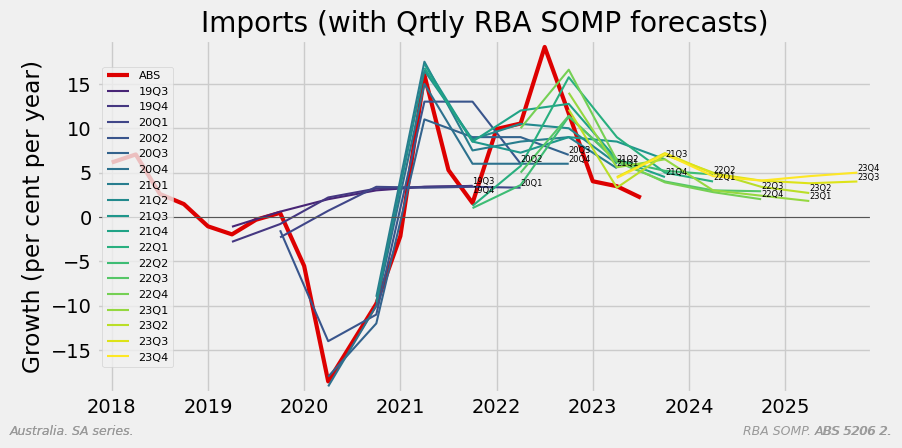

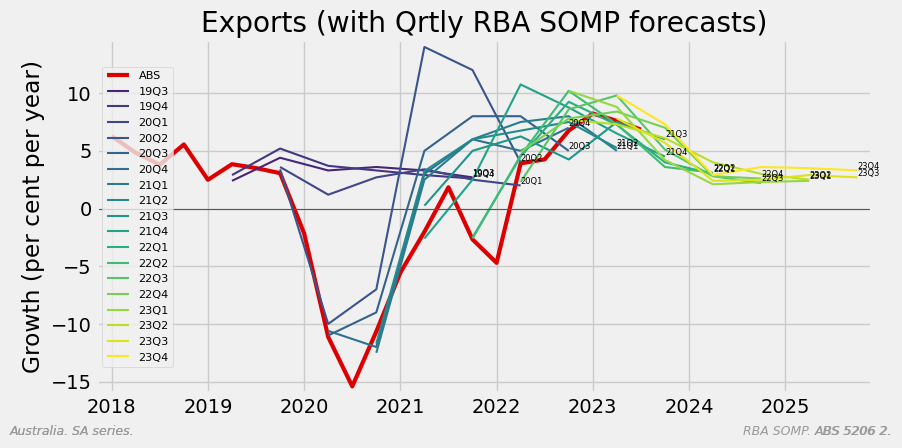

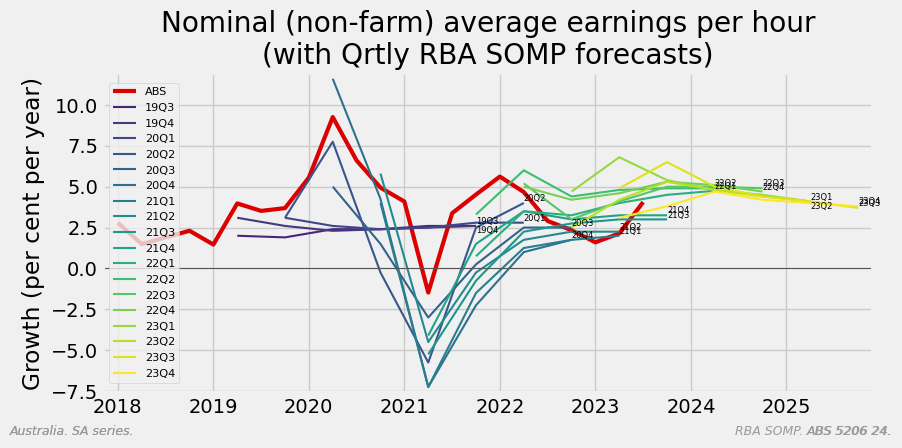

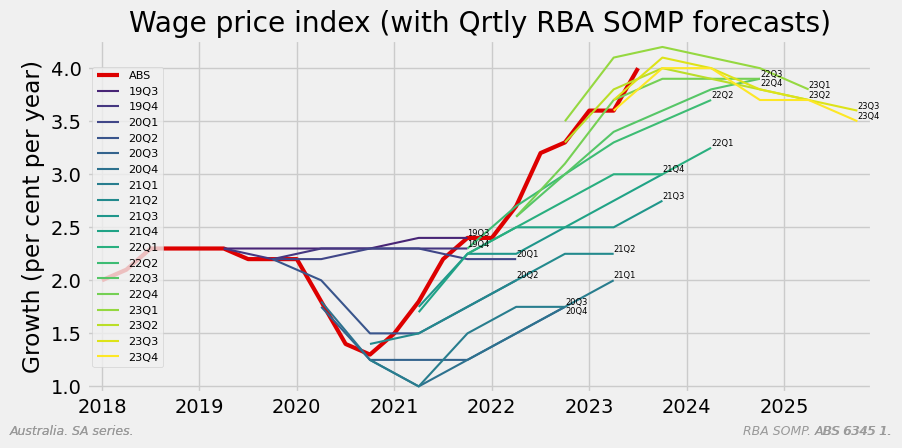

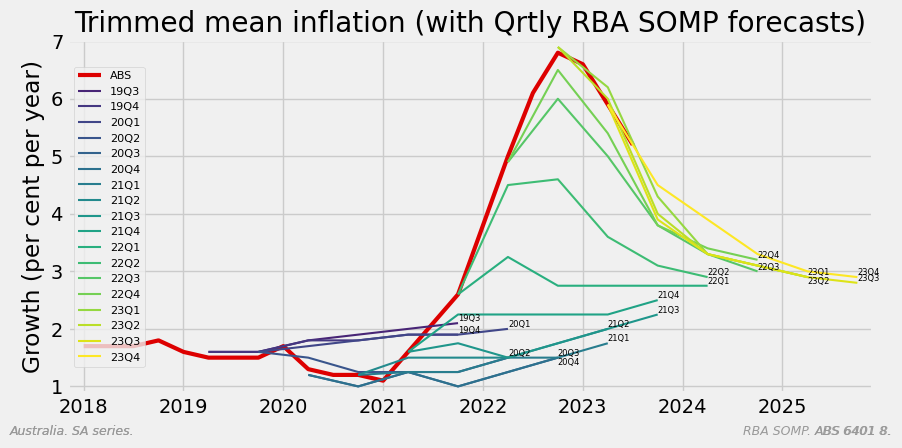

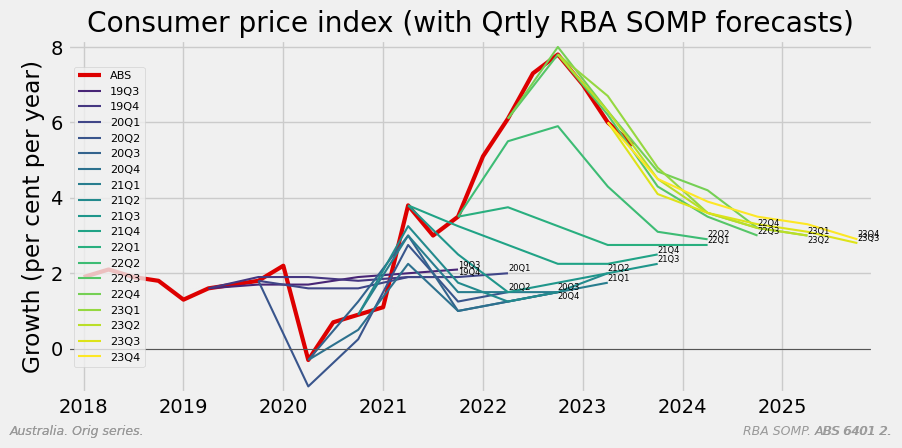

In [14]:
def plot_annual_growth(growth_data, measures):
    for m, series in growth_data.items():
        (cat, table, season, did1, did2, calc) = measures[m]
        ax = series[series.index.year >= START_YEAR-1].plot(
            lw=3, color="#dd0000", label=f"ABS"
        )
        finalise_plot(
            ax,
            title=m,
            ylabel="Growth (per cent per year)",
            lfooter=f"Australia. {season} series.",
            rfooter=f"ABS {cat} {table}.",
            #legend={"ncols": 1, "loc": "center left", "fontsize": "xx-small"},
            y0=True,
            dont_close=True,
        )

        df = somp[m]
        n_colours = len(df.columns)
        colors = plt.cm.viridis(np.linspace(0, 1, n_colours))
        xy = set()
        for col, color in zip(df.columns, colors):
            s = df[col].dropna()
            if s.index[0].year < START_YEAR:
                continue
            s.plot(ax=ax, lw=1.5, c=color, label=str(col)[2:])
            x, y = s.index[-1], s.iloc[-1]
            # let's minimise over-plotting of text
            va = "bottom" if (x, y) not in xy else "top"
            ax.text(x=x, y=y, s=str(col)[2:], fontsize=6, va=va)
            xy.add((x, y))

        title = f"{m} (with Qrtly RBA SOMP forecasts)"
        TOO_LONG = 55
        if len(title) > TOO_LONG:
            # replace the last occurrence
            old = " ("
            new = "\n("
            title = (title[::-1].replace(old[::-1],new[::-1], 1))[::-1]
        finalise_plot(
            ax,
            title=title,
            ylabel="Growth (per cent per year)",
            lfooter=f"Australia. {season} series.",
            rfooter=f"RBA SOMP. ABS {cat} {table}.",
            legend={"ncols": 1, "loc": "center left", "fontsize": "xx-small"},
            y0=True,
            show=SHOW,
        )


plot_annual_growth(abs_annual_growth, growth_measures)

## Real household disposable income
See table H from the RBA Statistical Tables: 'Real household disposable income' is household disposable income after the deduction of interest payments, deflated by the implicit price deflator for household consumption expenditure; includes income from unincorporated enterprises.

Disposable income
HFCE deflator


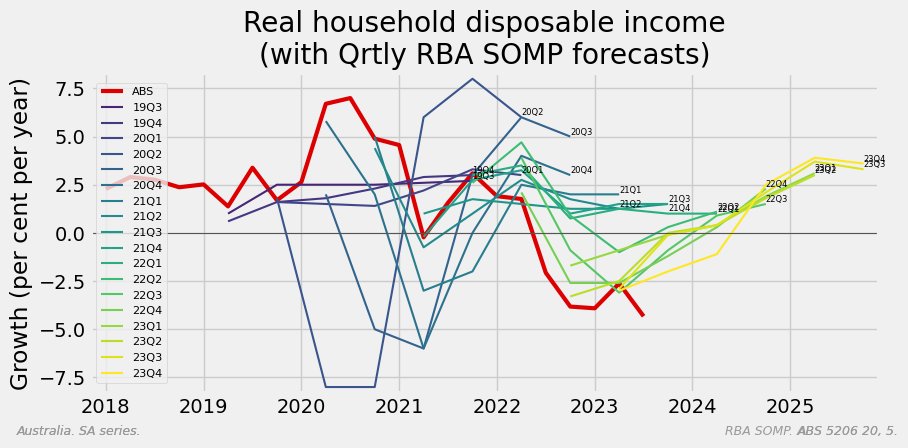

In [15]:
di_measures = {
    'Disposable income': [
        "5206",
        "20",
        "SA",
        "GROSS DISPOSABLE INCOME ;",
        "GROSS DISPOSABLE INCOME ;",
        False,
     ],
    'HFCE deflator': [
        "5206",
        "5",
        "SA",
        " ",
        "Households ;  Final consumption expenditure ;",
        False,
     ],
}

def plot_di():
    """Plot disposable income"""
    
    di_data = get_abs(di_measures)
    deflator = di_data['HFCE deflator'] / 100.0
    rhdi = di_data['Disposable income'] / deflator
    growth = (rhdi / rhdi.shift(4) - 1) * 100.0
    growth_data = {'Real household disposable income': growth}
    fake_measure = {
        'Real household disposable income': [
        "5206",
        ", ".join([x[1] for x in di_measures.values()]),
        "SA",
        "-",
        "-",
        False,
        ],
    }
    plot_annual_growth(growth_data, fake_measure)


plot_di()

## Unemployment rate

## Employment

## Finished

In [16]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Jan 23 2024 09:27:28

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

pandas    : 2.2.0
numpy     : 1.26.3
requests  : 2.31.0
matplotlib: 3.8.2

Watermark: 2.4.3



In [17]:
print("Finished.")

Finished.
